## Please don't run / don't click "Run all" the notebook:

At the time of writing of this document, the current core limit is 200 cores per workspace and depending upon number of concurrent users, you may end up with core capacity being exceeded or maximum number of parallel jobs being exceeded error.

# PPE Safety Compliance in Manufacturing - Hard Hat Detection  
<h3><span style="color: #117d30;"> Using Azure Custom Vision Congnitive Services</span></h3>

## Scenario Overview

**Azure Custom Vision** is a cognitive service which helps in building and deploying object detection and image classification models. 

This notebook provides an end-to-end demo on how to use the Azure Cognitive Services Custom Vision API to build and deploy an object detection model to detect **PPE compliance related to hard hats**. 

In this scenario we will see how the model provides the count of all workers and the count of workers wearing hard hats. All incidents of PPE non-compliance, where any worker is not wearing a hard hat, are marked as Non-Compliant. 



+ This demo uses real-world video footage from a manufacturing setting 
+ This raw video is stored in an ADLSGen2 storage container  
+ In this notebook, we process this raw video using Azure Custom Vision Cognitive Services model and get a processed video complete with: 

    * Moving Bounding boxes and moving tags for workers
    * Moving Bounding boxes and moving tags for hard hats
    * Count of workers and hard hats
    * Frame-wise annotation of Compliance and Non-Compliance 

## Setting-Up: 

+ Defining the storage, file path and file name for **raw input** video 
+ Defining the storage, file path and file name for **processed output** video

In [1]:
## setting up the credentials for ADLS Gen2
import os
from azure.storage.blob import BlockBlobService

# Importing user defined config
import config

# setting up blob storage configs
STORAGE_ACCOUNT_NAME = config.STORAGE_ACCOUNT_NAME
STORAGE_ACCOUNT_ACCESS_KEY = config.STORAGE_ACCOUNT_ACCESS_KEY
STORAGE_CONTAINER_NAME = "ppecompliancedetection"

# defining the folders for raw input video and processed output video  
input_folder="HardHat/Input/"
output_folder="HardHat/Output/"

# getting the file name from the folder in blob folder
blob_service = BlockBlobService(STORAGE_ACCOUNT_NAME, STORAGE_ACCOUNT_ACCESS_KEY) 

# providing the filename from input folder
input_file="threemenworkers.mp4"
output_file="processed_threemenworkers.mp4"
blob_file=input_folder + input_file

# downloading the file from the blob storage
download_file_path = os.path.join(os.getcwd(), input_file)
blob_service.get_blob_to_path(STORAGE_CONTAINER_NAME, blob_file ,download_file_path)

# defining the input and output video paths 
input_video_path=download_file_path
output_video_path=os.path.join(os.getcwd(), "Output",output_file)

## Installing OpenCV and importing other python libraries  

OpenCV is one of the most popular computer vision libraries for image and video processing. In this notebook, we will install python binding for  OpenCV. 

We will also import other libraries like  **matplotlib**,  **numpy**, **pandas**, etc. that are required at different stages in this notebook for manipulating and processing images.    

In [2]:
import os

# installing and importing the OpenCV library 
# openCV will be used to grab frames from video 
# and for converting the frames into arrays   
!pip install opencv-python-headless
!pip install grequests

import cv2 

# and for processing arrays   
import numpy as np

# for encoding and decoding Custom Vision predictions 
import json

# for converting the Custom Vision predictions to dataframe   
import pandas as pd

# making web service calls in batches
import grequests 

# for file name pattern matching   
import fnmatch  

# for displaying images from the processes output video   
import matplotlib.pyplot as plt

# importing other required libraries
import random
import textwrap
import datetime 
from PIL import Image
import time 

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/grequests.py:22: MonkeyPatchWarning: Monkey-patching ssl after ssl has already been imported may lead to errors, including RecursionError on Python 3.6. It may also silently lead to incorrect behaviour on Python 3.7. Please monkey-patch earlier. See https://github.com/gevent/gevent/issues/1016. Modules that had direct imports (NOT patched): ['urllib3.contrib.pyopenssl (/anaconda/envs/azureml_py36/lib/python3.6/site-packages/urllib3/contrib/pyopenssl.py)', 'urllib3.util (/anaconda/envs/azureml_py36/lib/python3.6/site-packages/urllib3/util/__init__.py)']. 
  curious_george.patch_all(thread=False, select=False)


## Making API call to Custom Vision Cognitive Service  

Now we will define connections details for making the API call to the Custom Vision Service 


In [3]:
# web service end-point for the Custom Vision model    
# we will process video frames (which are images)   
POST_URL = config.POST_URL
print(POST_URL)
# providing prediction key
HEADERS = config.HEADERS
print(HEADERS)

# number of API calls per pool of request   
MAX_CONNECTIONS = 100 

# initializing the height and width for frames in the video 
WIDTH = 0
HEIGHT = 0

## Functions to convert raw input video to processed video   
  

### function: getFrames

This function takes a  video as input and returns list of frames    

In [4]:
# returns frame array of video
def getFrames(path):
    images = []
    byteImages = []
    vidObj = cv2.VideoCapture(path)
    count = 0
    success = 1
    while success:
        success, image = vidObj.read()
        if success:
            images.append(image)
            count += 1
    global HEIGHT, WIDTH
    HEIGHT, WIDTH, lay = images[0].shape
    return images

### function: convertCVImagesToByteImages

This function takes a list of frames as input and returns list of Byte arrays   

In [5]:
# Returns ByteImages for POST request params
def convertCVImagesToByteImages(frames):
    toReturnByteImages = []
    for frame in frames:
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        is_success, im_buf_arr = cv2.imencode(".jpg", image)
        if is_success:
            byte_im = im_buf_arr.tobytes()
            toReturnByteImages.append(byte_im)
    return toReturnByteImages

### function: makeRequests 

This function takes a list of ByteImages and a prediction threshold as inputs and returns a list of bounding box co-ordinates, a list of tag data, and a list of Custom Vision service responses in data frames. The function calls some other functions that are also defined in this cell.    

In [6]:
# defining a function for making batch HTTP requests
def batchRequest(byteImages):
    results = []
    for x in range(0,len(byteImages)+1, MAX_CONNECTIONS):
        rs = (grequests.post(POST_URL,headers=HEADERS,data=u,stream=False) for u in byteImages[x:x+MAX_CONNECTIONS])
        time.sleep(0.2)
        results.extend(grequests.map(rs)) 
    response_list=[response.text for response in results]
    return response_list

# defining a function to convert raw JSON to a dataframe
def getDFfromResponse(response,threshold):
    resp = json.loads(response)
    pred= resp['predictions']
    pred_df=pd.DataFrame(pred)
    resp_df = pred_df[pred_df['probability'] > float(threshold)]
    return resp_df

# defining a function to converting the bounding box dataframe to a list 
def boundingBoxListFromDF(df):
    cood_list = df['boundingBox'].tolist()
    return cood_list

# defining a function for adjusting the size of bounding box 
def fitAccordingToSize(coods):
    print("Multiplying by " + str(WIDTH) + " , " + str(HEIGHT))
    for i in range(len(coods)):
        coods[i]['left']=coods[i]['left']*WIDTH
        coods[i]['top']=coods[i]['top']*HEIGHT
        coods[i]['width']=coods[i]['width']*WIDTH
        coods[i]['height']=coods[i]['height']*WIDTH
    return coods


#==================== function: makeRequests ====================#  
# defining a function to get bounding box coordinates and tags
# makes calls to other functions defined above 
def makeRequests(byteImages,threshold):
    tagsData = []
    bound_box_cood = []
    responseJSON =  []
    response_array=batchRequest(byteImages)
    for i,response in enumerate(response_array):
        df = getDFfromResponse(response, threshold)
        listBx = boundingBoxListFromDF(df)
        listBx = fitAccordingToSize(listBx)
        taglist = df['tagName'].tolist()
        tagsData.append(taglist)
        bound_box_cood.append(listBx)
        responseJSON.append(df)
    return bound_box_cood,tagsData,responseJSON 

### function: isCompliant 

This function takes a list of tags for a given frame as input and returns a Boolean after matching the count of worker tags and helmet tags.  

In [7]:
# defining a function to check compliance or non-compliance for a frame
def isCompliant(tags):
    return (len(list(filter(lambda x: x == 'helmet', tags))) == len(list(filter(lambda x: x == 'worker',tags)))) 


### function: printCNC

This function checks if a frame is compliant or non-compliant and then adds the appropriate labels. 

In [8]:
# Print Compliance Label
def PrintCompliance(frames,i,font,lineType):
    frames[i] = cv2.rectangle(
        frames[i], (WIDTH - 300, 0), (WIDTH, 50), (0, 128, 0), -1)
    frames[i] = cv2.putText(frames[i], "COMPLIANT",
                            (WIDTH - 220, 33),
                            font,
                            1,
                            (255, 255, 255), 2,
                            lineType)

# Print Non-Compliance Label
def PrintNonCompliance(frames, i, font, lineType):
    frames[i] = cv2.rectangle(
        frames[i], (WIDTH - 300, 0), (WIDTH, 50), (0, 0, 128), -1)
    frames[i] = cv2.putText(frames[i], "NON-COMPLIANT",
                            (WIDTH - 275, 34),
                            font,
                            1,
                            (255, 255, 255), 2,
                            lineType)  

#==================== function: printCNC ====================#  
# Check for compliance or non-compliance label
def printCNC(which, frames, i, font, lineType):
    if which:
        PrintCompliance(frames, i, font, lineType)
    else:
        PrintNonCompliance(frames, i, font, lineType)                                                      

### function: SaveVideo

We are using this function to convert a list of frames into a video.  


In [9]:
# defining a function to convert a list of frames into a video 
def SaveVideo(frames, output_file_name):
    img_array = []
    for img in frames:
        height, width, layers = img.shape
        size = (width,height)
        img_array.append(img)

    out = cv2.VideoWriter(output_file_name,cv2.VideoWriter_fourcc(*'MP4V'), 15, size)
    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()

## function: ConvertVideo 

This function combines raw frames into a processed video. It relies on several other functions that have been defined above. 

In [10]:
# defining a function to convert raw input video to processed video with tags and stats
def ConvertVideo(video_path, output_file_name, threshold, nframes):
    frames = getFrames(video_path) # this converts the input video into frames   
    
    if nframes != 'all':
        frames = frames[:int(nframes)]
    
    byteImages = convertCVImagesToByteImages(frames) # this converts frames into list of byte images
    
    coodsData,tagsData, responses = makeRequests(byteImages, threshold) # this returns lists of coordinate data, tag data, responses in dataframe   
    
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (50,50)
    fontScale              = 0.5
    fontColor              = (255,255,255)
    lineType               = 1
    frames_stats = []

    for i,coods_single in enumerate(coodsData):
        dflist = responses[i].drop('boundingBox', axis=1)
        print(dflist['tagId'])
        dflist['tagId'] = (dflist['tagId'].to_string())[-10:]
        dflist.reset_index(drop=True, inplace=True)
        d = dflist.to_dict(orient='records')
        jo = json.dumps(d)
        width = 600
        height = 1080
        blank_image=np.zeros((height, width, 3), np.uint8)
        n_helmets = len([x for x in tagsData[i] if x == 'helmet'])
        n_workers = len([x for x in tagsData[i] if x == 'worker'])
        color = (0, 0, 0)
        blank_image[:height//2] = color
        blank_image[height//2:] = (0, 0, 0)
        blank_image = cv2.putText(blank_image, "STATISTICS" ,(230, 70),font, 1,(66, 245,173),2 ,lineType)
        blank_image = cv2.rectangle(blank_image, (80,150), (width-60, 220), (66, 245,173), 2)
        blank_image = cv2.rectangle(blank_image, (80, 260), (width-60, 330), (66, 245, 173), 2)
        blank_image = cv2.putText(blank_image, "NO OF WORKERS:         "+ str(n_workers),(90+20, 195),font, 0.9,(66, 245,173),2 ,lineType)
        blank_image = cv2.putText(blank_image, "NO OF HELMETS:          "+ str(n_helmets),(90+20, 305),font, 0.9,(66, 245,173),2 ,lineType)
        relative_start = height//2 + - 150
        x, y0 = (50, relative_start)
        text = dflist.to_string()
        thickness = 10
        text_size, _ = cv2.getTextSize(text, font, fontScale, thickness)
        line_height = text_size[1] + 20
    
        if len(text) != 0:
            for k, line in enumerate(text.split("\n")):
                y = y0 + k * line_height
                relative_start = y
                if k == 0:
                    ctext = '      Probability      Id          Tag'
                    blank_image = cv2.putText(blank_image, ctext, (x, y), font, 0.8, (66, 245,173),2, lineType)
                else:
                    blank_image = cv2.putText(blank_image, line, (x, y), font, 0.8, (66, 245,173),2, lineType)
   
        wrapped_text = textwrap.wrap(jo, width=50)
        x, y0 = (10, relative_start)
    
        if relative_start > 700:
            y = relative_start
        else:
            y = 700
    
        for p, line in enumerate(wrapped_text):
            print(line)
            y = y + 30
            blank_image =  cv2.putText(blank_image, line, (10, y), font, 0.7, (66, 245,173),2, lineType)

        frames_stats.append(blank_image)
        last = None

        if len(tagsData[i]) == 0:
            pass

        elif not isCompliant(tagsData[i]): # this checks for compliance for the frame
            if i % 5 == 0:
                PrintNonCompliance(frames, i, font, lineType) # this prints non-compliant labels   
                last = 0
            else:
                if last == None:
                    PrintNonCompliance(frames, i, font, lineType) 
                    last = 0
                else:
                    printCNC(last, frames, font, lineType) # this checks for compliance before applying compliance labels

        else:
            if i % 5 == 0:
                PrintCompliance(frames, i, font, lineType) # this prints compliant labels 
                last = 1
            else:
                if last == None:
                    PrintCompliance(frames, i, font, lineType)
                    last = 1
                else:
                    printCNC(last, frames, font, lineType)

        for j,single in enumerate(coods_single):
            # this puts the tab on top of the detected item
            frames[i] = cv2.rectangle(frames[i],  (int(single['left']) - 3, int(single['top']) - 30), ((int(single['left']) + 100, int(single['top']) - 3)), (66, 245,173), -1)
            frames[i] = cv2.putText(frames[i],tagsData[i][j],
                (int(single['left'] + 2), int(single['top']) + - 8),
                font,
                0.9,
                (0,0,0),2,
                lineType)

            # this creates the bounding box
            frames[i] = cv2.rectangle(frames[i],  (int(single['left']), int(single['top'])), (int(single['left'])+int(single['width']), int(single['top'])+int(single['height'])), (66, 245,173) ,3)
       
        frames[i] = np.concatenate((frames[i], frames_stats[i]), axis=1)

    SaveVideo(frames, output_file_name) # this converts frames into a video
    stats_path = output_file_name.replace('Output', 'Stats')
    SaveVideo(frames_stats, stats_path)

## Video conversion and ADLSGen2 Storage  

We will make functions calls to convert the raw input video to processed video and store the processed video to ADLSGen2 storage. 

In [11]:
# creating Output and Stats directories for saving processed videos 
if not os.path.isdir("Output"):
   os.mkdir("Output")
if not os.path.isdir("Stats"):
   os.mkdir("Stats")

In [12]:
# converting raw input video to processed video complete with tags and stats
threshold=0.7
nframes="all"
ConvertVideo(input_video_path, output_video_path,threshold, nframes)

Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
M

Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
Multiplying by 1920 , 1080
M

[{"probability": 0.7694183, "tagId": "1103ac07ae",
"tagName": "worker"}, {"probability": 0.8012154,
"tagId": "1103ac07ae", "tagName": "worker"},
{"probability": 0.767743349, "tagId":
"1103ac07ae", "tagName": "worker"}]
48    49479b97-b9f2-44b7-823d-771103ac07ae
49    49479b97-b9f2-44b7-823d-771103ac07ae
50    49479b97-b9f2-44b7-823d-771103ac07ae
Name: tagId, dtype: object
[{"probability": 0.776159346, "tagId":
"1103ac07ae", "tagName": "worker"},
{"probability": 0.8064595, "tagId": "1103ac07ae",
"tagName": "worker"}, {"probability": 0.7716214,
"tagId": "1103ac07ae", "tagName": "worker"}]
48    49479b97-b9f2-44b7-823d-771103ac07ae
49    49479b97-b9f2-44b7-823d-771103ac07ae
50    49479b97-b9f2-44b7-823d-771103ac07ae
Name: tagId, dtype: object
[{"probability": 0.7784058, "tagId": "1103ac07ae",
"tagName": "worker"}, {"probability": 0.803280056,
"tagId": "1103ac07ae", "tagName": "worker"},
{"probability": 0.771363437, "tagId":
"1103ac07ae", "tagName": "worker"}]
46    49479b97-b9f2-44b7-823d

[{"probability": 0.70634675, "tagId":
"1103ac07ae", "tagName": "worker"},
{"probability": 0.714248836, "tagId":
"1103ac07ae", "tagName": "worker"},
{"probability": 0.717877269, "tagId":
"1103ac07ae", "tagName": "worker"}]
44    49479b97-b9f2-44b7-823d-771103ac07ae
45    49479b97-b9f2-44b7-823d-771103ac07ae
46    49479b97-b9f2-44b7-823d-771103ac07ae
Name: tagId, dtype: object
[{"probability": 0.7206434, "tagId": "1103ac07ae",
"tagName": "worker"}, {"probability": 0.7146772,
"tagId": "1103ac07ae", "tagName": "worker"},
{"probability": 0.7199315, "tagId": "1103ac07ae",
"tagName": "worker"}]
43    49479b97-b9f2-44b7-823d-771103ac07ae
44    49479b97-b9f2-44b7-823d-771103ac07ae
45    49479b97-b9f2-44b7-823d-771103ac07ae
Name: tagId, dtype: object
[{"probability": 0.717163265, "tagId":
"1103ac07ae", "tagName": "worker"},
{"probability": 0.7187369, "tagId": "1103ac07ae",
"tagName": "worker"}, {"probability": 0.7215226,
"tagId": "1103ac07ae", "tagName": "worker"}]
40    49479b97-b9f2-44b7-823d-

[{"probability": 0.767913043, "tagId":
"1103ac07ae", "tagName": "worker"},
{"probability": 0.737533, "tagId": "1103ac07ae",
"tagName": "worker"}]
37    49479b97-b9f2-44b7-823d-771103ac07ae
38    49479b97-b9f2-44b7-823d-771103ac07ae
39    49479b97-b9f2-44b7-823d-771103ac07ae
Name: tagId, dtype: object
[{"probability": 0.775625944, "tagId":
"1103ac07ae", "tagName": "worker"},
{"probability": 0.707778156, "tagId":
"1103ac07ae", "tagName": "worker"},
{"probability": 0.7231647, "tagId": "1103ac07ae",
"tagName": "worker"}]
37    49479b97-b9f2-44b7-823d-771103ac07ae
38    49479b97-b9f2-44b7-823d-771103ac07ae
39    49479b97-b9f2-44b7-823d-771103ac07ae
Name: tagId, dtype: object
[{"probability": 0.773842335, "tagId":
"1103ac07ae", "tagName": "worker"},
{"probability": 0.733417869, "tagId":
"1103ac07ae", "tagName": "worker"},
{"probability": 0.745387, "tagId": "1103ac07ae",
"tagName": "worker"}]
37    49479b97-b9f2-44b7-823d-771103ac07ae
38    49479b97-b9f2-44b7-823d-771103ac07ae
39    49479b97-

[]
Series([], Name: tagId, dtype: object)
[]
Series([], Name: tagId, dtype: object)
[]
Series([], Name: tagId, dtype: object)
[]
Series([], Name: tagId, dtype: object)
[]
Series([], Name: tagId, dtype: object)
[]
Series([], Name: tagId, dtype: object)
[]
Series([], Name: tagId, dtype: object)
[]
Series([], Name: tagId, dtype: object)
[]
Series([], Name: tagId, dtype: object)
[]
Series([], Name: tagId, dtype: object)
[]
Series([], Name: tagId, dtype: object)
[]
Series([], Name: tagId, dtype: object)
[]
Series([], Name: tagId, dtype: object)
[]
Series([], Name: tagId, dtype: object)
[]
Series([], Name: tagId, dtype: object)
[]
Series([], Name: tagId, dtype: object)
[]
Series([], Name: tagId, dtype: object)
[]
Series([], Name: tagId, dtype: object)
[]
Series([], Name: tagId, dtype: object)
[]
Series([], Name: tagId, dtype: object)
[]
Series([], Name: tagId, dtype: object)
[]
Series([], Name: tagId, dtype: object)
[]
Series([], Name: tagId, dtype: object)
[]
Series([], Name: tagId, dtype: 

4     61bd2a42-91bb-404f-8a1e-b6fe16d637c3
6     61bd2a42-91bb-404f-8a1e-b6fe16d637c3
50    49479b97-b9f2-44b7-823d-771103ac07ae
52    49479b97-b9f2-44b7-823d-771103ac07ae
Name: tagId, dtype: object
[{"probability": 0.752773762, "tagId":
"1103ac07ae", "tagName": "helmet"},
{"probability": 0.7732798, "tagId": "1103ac07ae",
"tagName": "helmet"}, {"probability": 0.718992531,
"tagId": "1103ac07ae", "tagName": "worker"},
{"probability": 0.759053, "tagId": "1103ac07ae",
"tagName": "worker"}]
4     61bd2a42-91bb-404f-8a1e-b6fe16d637c3
6     61bd2a42-91bb-404f-8a1e-b6fe16d637c3
46    49479b97-b9f2-44b7-823d-771103ac07ae
47    49479b97-b9f2-44b7-823d-771103ac07ae
48    49479b97-b9f2-44b7-823d-771103ac07ae
Name: tagId, dtype: object
[{"probability": 0.7162966, "tagId": "1103ac07ae",
"tagName": "helmet"}, {"probability": 0.700280547,
"tagId": "1103ac07ae", "tagName": "helmet"},
{"probability": 0.7301758, "tagId": "1103ac07ae",
"tagName": "worker"}, {"probability": 0.7094606,
"tagId": "1103ac07ae"

3     61bd2a42-91bb-404f-8a1e-b6fe16d637c3
46    49479b97-b9f2-44b7-823d-771103ac07ae
47    49479b97-b9f2-44b7-823d-771103ac07ae
49    49479b97-b9f2-44b7-823d-771103ac07ae
Name: tagId, dtype: object
[{"probability": 0.799458742, "tagId":
"1103ac07ae", "tagName": "helmet"},
{"probability": 0.7729758, "tagId": "1103ac07ae",
"tagName": "worker"}, {"probability": 0.7297246,
"tagId": "1103ac07ae", "tagName": "worker"},
{"probability": 0.7353392, "tagId": "1103ac07ae",
"tagName": "worker"}]
5     61bd2a42-91bb-404f-8a1e-b6fe16d637c3
7     61bd2a42-91bb-404f-8a1e-b6fe16d637c3
46    49479b97-b9f2-44b7-823d-771103ac07ae
47    49479b97-b9f2-44b7-823d-771103ac07ae
48    49479b97-b9f2-44b7-823d-771103ac07ae
Name: tagId, dtype: object
[{"probability": 0.8447106, "tagId": "1103ac07ae",
"tagName": "helmet"}, {"probability": 0.773538053,
"tagId": "1103ac07ae", "tagName": "helmet"},
{"probability": 0.767663836, "tagId":
"1103ac07ae", "tagName": "worker"},
{"probability": 0.709483445, "tagId":
"1103ac07

[{"probability": 0.7843746, "tagId": "1103ac07ae",
"tagName": "helmet"}, {"probability": 0.785364,
"tagId": "1103ac07ae", "tagName": "worker"},
{"probability": 0.750727832, "tagId":
"1103ac07ae", "tagName": "worker"},
{"probability": 0.767787158, "tagId":
"1103ac07ae", "tagName": "worker"}]
7     61bd2a42-91bb-404f-8a1e-b6fe16d637c3
49    49479b97-b9f2-44b7-823d-771103ac07ae
50    49479b97-b9f2-44b7-823d-771103ac07ae
51    49479b97-b9f2-44b7-823d-771103ac07ae
Name: tagId, dtype: object
[{"probability": 0.709783554, "tagId":
"1103ac07ae", "tagName": "helmet"},
{"probability": 0.801207542, "tagId":
"1103ac07ae", "tagName": "worker"},
{"probability": 0.7662312, "tagId": "1103ac07ae",
"tagName": "worker"}, {"probability": 0.783168733,
"tagId": "1103ac07ae", "tagName": "worker"}]
6     61bd2a42-91bb-404f-8a1e-b6fe16d637c3
43    49479b97-b9f2-44b7-823d-771103ac07ae
44    49479b97-b9f2-44b7-823d-771103ac07ae
45    49479b97-b9f2-44b7-823d-771103ac07ae
Name: tagId, dtype: object
[{"probability"

1     61bd2a42-91bb-404f-8a1e-b6fe16d637c3
2     61bd2a42-91bb-404f-8a1e-b6fe16d637c3
3     61bd2a42-91bb-404f-8a1e-b6fe16d637c3
39    49479b97-b9f2-44b7-823d-771103ac07ae
40    49479b97-b9f2-44b7-823d-771103ac07ae
41    49479b97-b9f2-44b7-823d-771103ac07ae
Name: tagId, dtype: object
[{"probability": 0.7081107, "tagId": "1103ac07ae",
"tagName": "helmet"}, {"probability": 0.7848356,
"tagId": "1103ac07ae", "tagName": "helmet"},
{"probability": 0.8276773, "tagId": "1103ac07ae",
"tagName": "helmet"}, {"probability": 0.769304752,
"tagId": "1103ac07ae", "tagName": "worker"},
{"probability": 0.7248441, "tagId": "1103ac07ae",
"tagName": "worker"}, {"probability": 0.77241,
"tagId": "1103ac07ae", "tagName": "worker"}]
2     61bd2a42-91bb-404f-8a1e-b6fe16d637c3
3     61bd2a42-91bb-404f-8a1e-b6fe16d637c3
4     61bd2a42-91bb-404f-8a1e-b6fe16d637c3
41    49479b97-b9f2-44b7-823d-771103ac07ae
42    49479b97-b9f2-44b7-823d-771103ac07ae
43    49479b97-b9f2-44b7-823d-771103ac07ae
Name: tagId, dtype: obje

[{"probability": 0.8736356, "tagId": "1103ac07ae",
"tagName": "helmet"}, {"probability": 0.885175645,
"tagId": "1103ac07ae", "tagName": "helmet"},
{"probability": 0.8490554, "tagId": "1103ac07ae",
"tagName": "helmet"}, {"probability": 0.780076265,
"tagId": "1103ac07ae", "tagName": "worker"},
{"probability": 0.7731675, "tagId": "1103ac07ae",
"tagName": "worker"}, {"probability": 0.7636392,
"tagId": "1103ac07ae", "tagName": "worker"}]
2     61bd2a42-91bb-404f-8a1e-b6fe16d637c3
3     61bd2a42-91bb-404f-8a1e-b6fe16d637c3
4     61bd2a42-91bb-404f-8a1e-b6fe16d637c3
42    49479b97-b9f2-44b7-823d-771103ac07ae
43    49479b97-b9f2-44b7-823d-771103ac07ae
44    49479b97-b9f2-44b7-823d-771103ac07ae
Name: tagId, dtype: object
[{"probability": 0.8782899, "tagId": "1103ac07ae",
"tagName": "helmet"}, {"probability": 0.8831229,
"tagId": "1103ac07ae", "tagName": "helmet"},
{"probability": 0.8408751, "tagId": "1103ac07ae",
"tagName": "helmet"}, {"probability": 0.782880545,
"tagId": "1103ac07ae", "tagName"

[{"probability": 0.779060364, "tagId":
"1103ac07ae", "tagName": "helmet"},
{"probability": 0.893539548, "tagId":
"1103ac07ae", "tagName": "helmet"},
{"probability": 0.822305, "tagId": "1103ac07ae",
"tagName": "worker"}, {"probability": 0.862526238,
"tagId": "1103ac07ae", "tagName": "worker"},
{"probability": 0.7455022, "tagId": "1103ac07ae",
"tagName": "worker"}]
1     61bd2a42-91bb-404f-8a1e-b6fe16d637c3
4     61bd2a42-91bb-404f-8a1e-b6fe16d637c3
35    49479b97-b9f2-44b7-823d-771103ac07ae
36    49479b97-b9f2-44b7-823d-771103ac07ae
37    49479b97-b9f2-44b7-823d-771103ac07ae
Name: tagId, dtype: object
[{"probability": 0.734367549, "tagId":
"1103ac07ae", "tagName": "helmet"},
{"probability": 0.89020896, "tagId": "1103ac07ae",
"tagName": "helmet"}, {"probability": 0.830094159,
"tagId": "1103ac07ae", "tagName": "worker"},
{"probability": 0.8679488, "tagId": "1103ac07ae",
"tagName": "worker"}, {"probability": 0.717645645,
"tagId": "1103ac07ae", "tagName": "worker"}]
2     61bd2a42-91bb-404f

[{"probability": 0.917686462, "tagId":
"1103ac07ae", "tagName": "helmet"},
{"probability": 0.9248758, "tagId": "1103ac07ae",
"tagName": "helmet"}, {"probability": 0.920744538,
"tagId": "1103ac07ae", "tagName": "worker"},
{"probability": 0.814571261, "tagId":
"1103ac07ae", "tagName": "worker"},
{"probability": 0.829554, "tagId": "1103ac07ae",
"tagName": "worker"}]
2     61bd2a42-91bb-404f-8a1e-b6fe16d637c3
3     61bd2a42-91bb-404f-8a1e-b6fe16d637c3
34    49479b97-b9f2-44b7-823d-771103ac07ae
35    49479b97-b9f2-44b7-823d-771103ac07ae
36    49479b97-b9f2-44b7-823d-771103ac07ae
Name: tagId, dtype: object
[{"probability": 0.9113337, "tagId": "1103ac07ae",
"tagName": "helmet"}, {"probability": 0.9208818,
"tagId": "1103ac07ae", "tagName": "helmet"},
{"probability": 0.911727369, "tagId":
"1103ac07ae", "tagName": "worker"},
{"probability": 0.8281287, "tagId": "1103ac07ae",
"tagName": "worker"}, {"probability": 0.8308107,
"tagId": "1103ac07ae", "tagName": "worker"}]
2     61bd2a42-91bb-404f-8a1e

In [13]:
%%capture

# uploading the processed video to the Output directory in the ADLSGen2 storage container
output_blob_file= output_folder + output_file
blob_service.create_blob_from_path(STORAGE_CONTAINER_NAME,output_blob_file ,output_video_path)

## Displaying frames from processed video


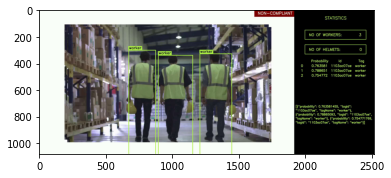

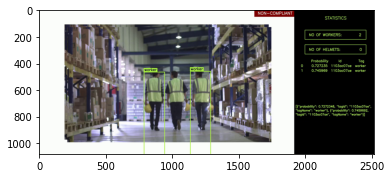

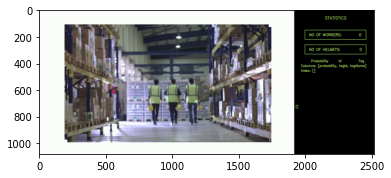

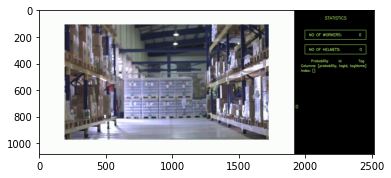

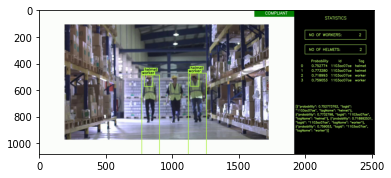

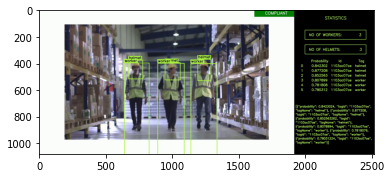

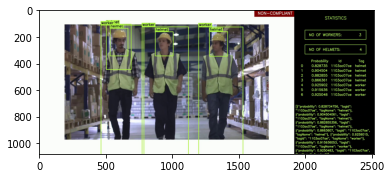

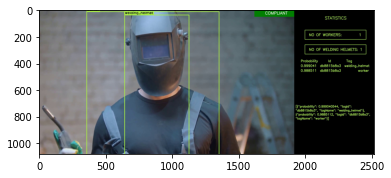

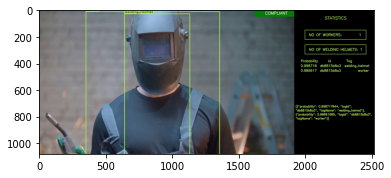

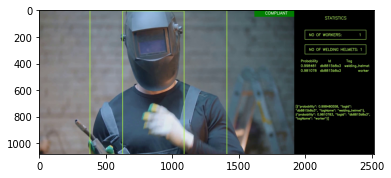

In [14]:
# saving processed video as images inside the frames directory
images = []
byteImages = []
vidObj = cv2.VideoCapture(output_video_path)
count = 0
success = 1
currentDir = os.getcwd()
if not os.path.isdir("frames"):
   os.mkdir("frames")
while success:
      success, image = vidObj.read()
      if success:
          cv2.imwrite("frames/frame%d.jpg" % count, image) 
          count += 1

images_num=(len(fnmatch.filter(os.listdir(os.getcwd() + "/frames"), '*.jpg')))

# displaying images from frames directory
i=0
for i in range(images_num):
    if i%75==0:
      a = plt.imread("frames/frame%d.jpg" % i)
      plt.imshow(a)
      plt.show()